In [1]:
import numpy as np
from typing import List, Tuple, Dict
import os
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("/yezhirui/evo_probe")
from src.find_contact import get_critical_contacts


def load_mj_matrix(mj_file_path: str,standardize: bool = False) -> Dict[Tuple[str, str], float]:
    """加载MJ矩阵文件"""
    with open(mj_file_path, 'r') as f:
        lines = f.readlines()
    
    header = lines[0].strip().split()
    amino_acids = header
    n_aa = len(amino_acids)
    
    matrix = np.zeros((n_aa, n_aa))
    for i, line in enumerate(lines[1:]):
        values = line.strip().split()
        for j, value in enumerate(values):
            if value != '0.00e+00':
                matrix[i, j] = float(value)
                matrix[j, i] = float(value)
    
    if standardize:
        scaler = StandardScaler()
        matrix = scaler.fit_transform(matrix)
    
    # 创建查询字典
    mj_dict = {}
    for i, aa1 in enumerate(amino_acids):
        for j, aa2 in enumerate(amino_acids):
            mj_dict[(aa1, aa2)] = matrix[i, j]
            mj_dict[(aa2, aa1)] = matrix[i, j]
    
    return mj_dict


def generate_contact_embedding(msa_path: str,
                      target_contacts: List[Tuple[int, int]],
                      mj_dict: Dict,
                      standardize: bool = True) -> np.ndarray:
    from Bio import SeqIO
    from sklearn.preprocessing import StandardScaler    

    # 读取序列
    sequences = []
    with open(msa_path, 'r') as f:
        for record in SeqIO.parse(f, "fasta"):
            sequences.append(str(record.seq))
    
    m, d = len(sequences), len(target_contacts)
    X = np.zeros((m, d))
    
    # 构建embedding
    for seq_idx, sequence in enumerate(sequences):
        for contact_idx, (i, j) in enumerate(target_contacts):
            if i < len(sequence) and j < len(sequence):
                res_i, res_j = sequence[i], sequence[j]
                if res_i != '-' and res_j != '-':
                        mj_energy = mj_dict.get((res_i.upper(), res_j.upper()), 0)
                        X[seq_idx, contact_idx] = mj_energy  
    
    # 标准化
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    return X

## GMM analysis

In [2]:
def gmm_bic_analysis(X: np.ndarray, max_k: int = 10, random_state: int = 42, verbose: bool = True) -> Tuple[List[int], List[float], int]:
    """
    使用高斯混合模型(GMM)拟合数据并计算BIC分数
    
    Args:
        X: 高维向量数据 (n_samples, n_features)
        max_k: 最大聚类数k
        random_state: 随机种子
        verbose: 是否打印详细信息
        
    Returns:
        (k_values, bic_scores, best_k): k值列表、BIC分数列表、最优k值
    """
    from sklearn.mixture import GaussianMixture
    
    k_values = list(range(1, max_k + 1))
    bic_scores = []
    aic_scores = []
    models = []
    
    if verbose:
        print("k\tBIC分数\t\t对数似然")
        print("-" * 35)
    
    for k in k_values:
        # 拟合GMM模型
        gmm = GaussianMixture(
            n_components=k,
            random_state=random_state,
            max_iter=100,
            covariance_type='full'  # 完整协方差矩阵
        )
        
        gmm.fit(X)
        
        # 计算BIC分数
        bic = gmm.bic(X)
        # aic = gmm.aic(X)
        log_likelihood = gmm.score(X) * len(X)  # 总对数似然
        
        bic_scores.append(bic)
        # aic_scores.append(aic)
        models.append(gmm)
        
        if verbose:
            print(f"{k}\t{bic:.2f}\t\t{log_likelihood:.2f}")
    
    # 选择最优k值（BIC最小）
    best_k = k_values[np.argmin(bic_scores)]
    
    if verbose:
        print(f"\n最优k值: {best_k} (BIC = {min(bic_scores):.2f})")
    
    return k_values, bic_scores, best_k


def plot_bic_curve(k_values: List[int], bic_scores: List[float], title: str = "GMM BIC分数曲线"):
    """
    绘制BIC分数曲线
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, bic_scores, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('num of cluster k')
    plt.ylabel('BIC score')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    # 标记最优点
    best_idx = np.argmin(bic_scores)
    plt.plot(k_values[best_idx], bic_scores[best_idx], 'ro', markersize=12, 
             label=f'best k={k_values[best_idx]}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()




def gmm_cluster_analysis(X: np.ndarray, k: int, random_state: int = 42):
    """
    使用指定k值进行GMM聚类分析
    
    Returns:
        (gmm_model, labels, probabilities): GMM模型、聚类标签、后验概率
    """
    from sklearn.mixture import GaussianMixture
    
    gmm = GaussianMixture(
        n_components=k,
        random_state=random_state,
        max_iter=100,
        covariance_type='full'
    )
    
    gmm.fit(X)
    labels = gmm.predict(X)
    probabilities = gmm.predict_proba(X)
    
    return gmm, labels, probabilities

## GMM guided projection

In [6]:
def gmm_guided_projection(X: np.ndarray, 
                       k: int = 2,
                       random_state: int = 42,
                       visualize: bool = True,
                       figsize: Tuple[int, int] = (15, 5)) -> Dict[str, any]:
    """
    使用GMM中心点定义的投影轴进行投影
    
    Args:
        X: 高维数据 (n_samples, n_features)
        k: GMM聚类数量，建议设为2来找到最佳分离方向
        random_state: 随机种子
        visualize: 是否可视化结果
        figsize: 图片大小
        
    Returns:
        Dict: 包含完整分析结果的字典
    """
    try:
        from diptest import diptest
    except ImportError:
        raise ImportError("需要安装diptest包: pip install diptest")
        
    from sklearn.mixture import GaussianMixture
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    
    print(f"=== 基于GMM指导的Dip Test (k={k}) ===")
    
    # 步骤1: 拟合GMM模型
    print("步骤1: 拟合GMM模型...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    gmm = GaussianMixture(n_components=k, random_state=random_state, max_iter=100)
    gmm.fit(X_scaled)
    
    # 获取聚类标签和概率
    labels = gmm.predict(X_scaled)
    probabilities = gmm.predict_proba(X_scaled)
    
    print(f"GMM拟合完成")
    print(f"各聚类大小: {np.bincount(labels)}")
    print(f"BIC分数: {gmm.bic(X_scaled):.2f}")
    
    # 步骤2: 提取聚类中心点
    print("\n步骤2: 提取聚类中心点...")
    centers = gmm.means_  # shape: (k, n_features)
    
    if k == 2:
        center_A, center_B = centers[0], centers[1]
        print(f"中心A形状: {center_A.shape}")
        print(f"中心B形状: {center_B.shape}")
        
        # 计算连接两个中心的向量V
        projection_vector = center_B - center_A
        print(f"投影向量V形状: {projection_vector.shape}")
        print(f"投影向量V模长: {np.linalg.norm(projection_vector):.4f}")
        
    else:
        # 对于k>2的情况，找到距离最远的两个中心
        max_dist = 0
        best_pair = (0, 1)
        
        for i in range(k):
            for j in range(i+1, k):
                dist = np.linalg.norm(centers[i] - centers[j])
                if dist > max_dist:
                    max_dist = dist
                    best_pair = (i, j)
        
        center_A, center_B = centers[best_pair[0]], centers[best_pair[1]]
        projection_vector = center_B - center_A
        print(f"选择聚类{best_pair[0]}和{best_pair[1]}作为投影轴 (距离={max_dist:.4f})")
    
    # 步骤3: 将数据投影到一维
    print("\n步骤3: 投影数据到一维...")
    projected_data = X_scaled @ projection_vector  # 点积运算
    print(f"投影后数据形状: {projected_data.shape}")
    print(f"投影数据范围: [{projected_data.min():.4f}, {projected_data.max():.4f}]")
    
    
    
    # 可视化结果
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # 子图1: 投影数据的直方图
        ax1 = axes[0]
        n_bins = min(50, len(np.unique(projected_data)))
        ax1.hist(projected_data, bins=n_bins, alpha=0.7, density=True, 
                color='skyblue', edgecolor='black')
        ax1.set_title(f'projection data distribution', 
                      fontweight='bold')
        ax1.set_xlabel('projection value')
        ax1.set_ylabel('density')
        ax1.grid(True, alpha=0.3)
        
        
        # 子图2: 不同聚类的投影分布
        ax2 = axes[1]
        for cluster_id in range(k):
            mask = labels == cluster_id
            cluster_projected = projected_data[mask]
            ax2.hist(cluster_projected, bins=20, alpha=0.6, density=True,
                    label=f'cluster{cluster_id} (n={np.sum(mask)})')
        
        ax2.set_title('projection value distribution of each cluster')
        ax2.set_xlabel('projection value')
        ax2.set_ylabel('density')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 子图3: 聚类概率分布
        ax3 = axes[2]
        if k == 2:
            # 对于2聚类，显示分类确定性
            max_probs = np.max(probabilities, axis=1)
            ax3.hist(max_probs, bins=30, alpha=0.7, color='orange', edgecolor='black')
            ax3.set_title('cluster certainty distribution')
            ax3.set_xlabel('maximum posterior probability')
            ax3.set_ylabel('frequency')
            
            # 添加统计信息
            uncertain_count = np.sum(max_probs < 0.8)  # 低确定性点
            ax3.text(0.05, 0.95, f'low certainty points: {uncertain_count}/{len(max_probs)}', 
                    transform=ax3.transAxes, fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        else:
            # 对于多聚类，显示各聚类大小
            cluster_sizes = np.bincount(labels)
            ax3.bar(range(k), cluster_sizes, alpha=0.7, color='orange')
            ax3.set_title('cluster sizes')
            ax3.set_xlabel('cluster ID')
            ax3.set_ylabel('sample number')
            
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # 返回完整结果
    results = {
        'projected_data': projected_data,
        'gmm_model': gmm,
        'labels': labels,
        'probabilities': probabilities,
        'centers': centers,
        'projection_vector': projection_vector,
        'center_A': center_A,
        'center_B': center_B,
        'cluster_sizes': np.bincount(labels),
        'bic_score': gmm.bic(X_scaled),
        'total_samples': len(projected_data)
    }
    
    return results


def compare_gmm_guided_projections(datasets: Dict[str, np.ndarray],
                                k: int = 2,
                                figsize: Tuple[int, int] = (18, 12)) -> Dict[str, Dict]:
    """
    比较多个数据集的GMM指导投影
    """
    import matplotlib.pyplot as plt
    
    all_results = {}
    
    # 对每个数据集进行测试
    for name, data in datasets.items():
        print(f"\n{'='*60}")
        print(f"dataset: {name}")
        print(f"shape: {data.shape}")
        
        results = gmm_guided_projection(data, k=k, visualize=False)
        all_results[name] = results
    
    # 汇总可视化
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=figsize)
    if n_datasets == 1:
        axes = [axes]  # 转换为列表而不是reshape
    
    dataset_names = list(datasets.keys())
    
    
    
    # 聚类分布对比
    for i, (name, results) in enumerate(all_results.items()):
        ax = axes[i]
        projected_data = results['projected_data']
        labels = results['labels'] 
        total_samples = results['total_samples']
        
        for cluster_id in range(k):
            mask = labels == cluster_id
            if np.any(mask):
                cluster_projected = projected_data[mask]
                # ax.hist(cluster_projected, bins=20, alpha=0.6, density=True,
                    #    label=f'cluster {cluster_id} (n={np.sum(mask)})')
                cluster_weights = np.ones(len(cluster_projected)) / total_samples
                ax.hist(cluster_projected, bins=20, alpha=0.6, weights=cluster_weights,
                       label=f'cluster{cluster_id} (n={np.sum(mask)})')
        
        ax.set_title(f'{name} - cluster distribution')
        ax.set_xlabel('projection value')
        ax.set_ylabel('density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    

    return all_results

In [4]:
chemokine_pdb = "1j8i"  # 趋化因子折叠
alternate_pdb = "2jp1"  # 替代折叠
new_contacts, lost_contacts = get_critical_contacts(chemokine_pdb, alternate_pdb,threshold=10.0,remove_diag=5)
critical_contacts = new_contacts + lost_contacts
print(f"新形成接触: {len(new_contacts)} 个")
print(f"断开接触: {len(lost_contacts)} 个")

PDB坐标提取完成: 93 个残基 (链 A)
PDB坐标提取完成: 60 个残基 (链 A)
距离矩阵计算完成: 93 x 93
距离矩阵计算完成: 60 x 60
共同残基数量: 60 个 (原始: 93 vs 60)
新形成接触: 111 个
断开接触: 133 个


contact_embedding shape: (1000, 244)

dataset: ANC0
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [973  27]
BIC分数: -469178.24

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 19.7300

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-150.5095, 515.5143]

dataset: ANC1
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [968  32]
BIC分数: -400967.84

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 11.9652

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-68.6043, 234.6003]

dataset: ANC2
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [985  15]
BIC分数: 65042.54

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 17.9522

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-93.1752, 418.0281]

dataset: ANC3
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [856 144]
BIC分数: -1021769.14

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)

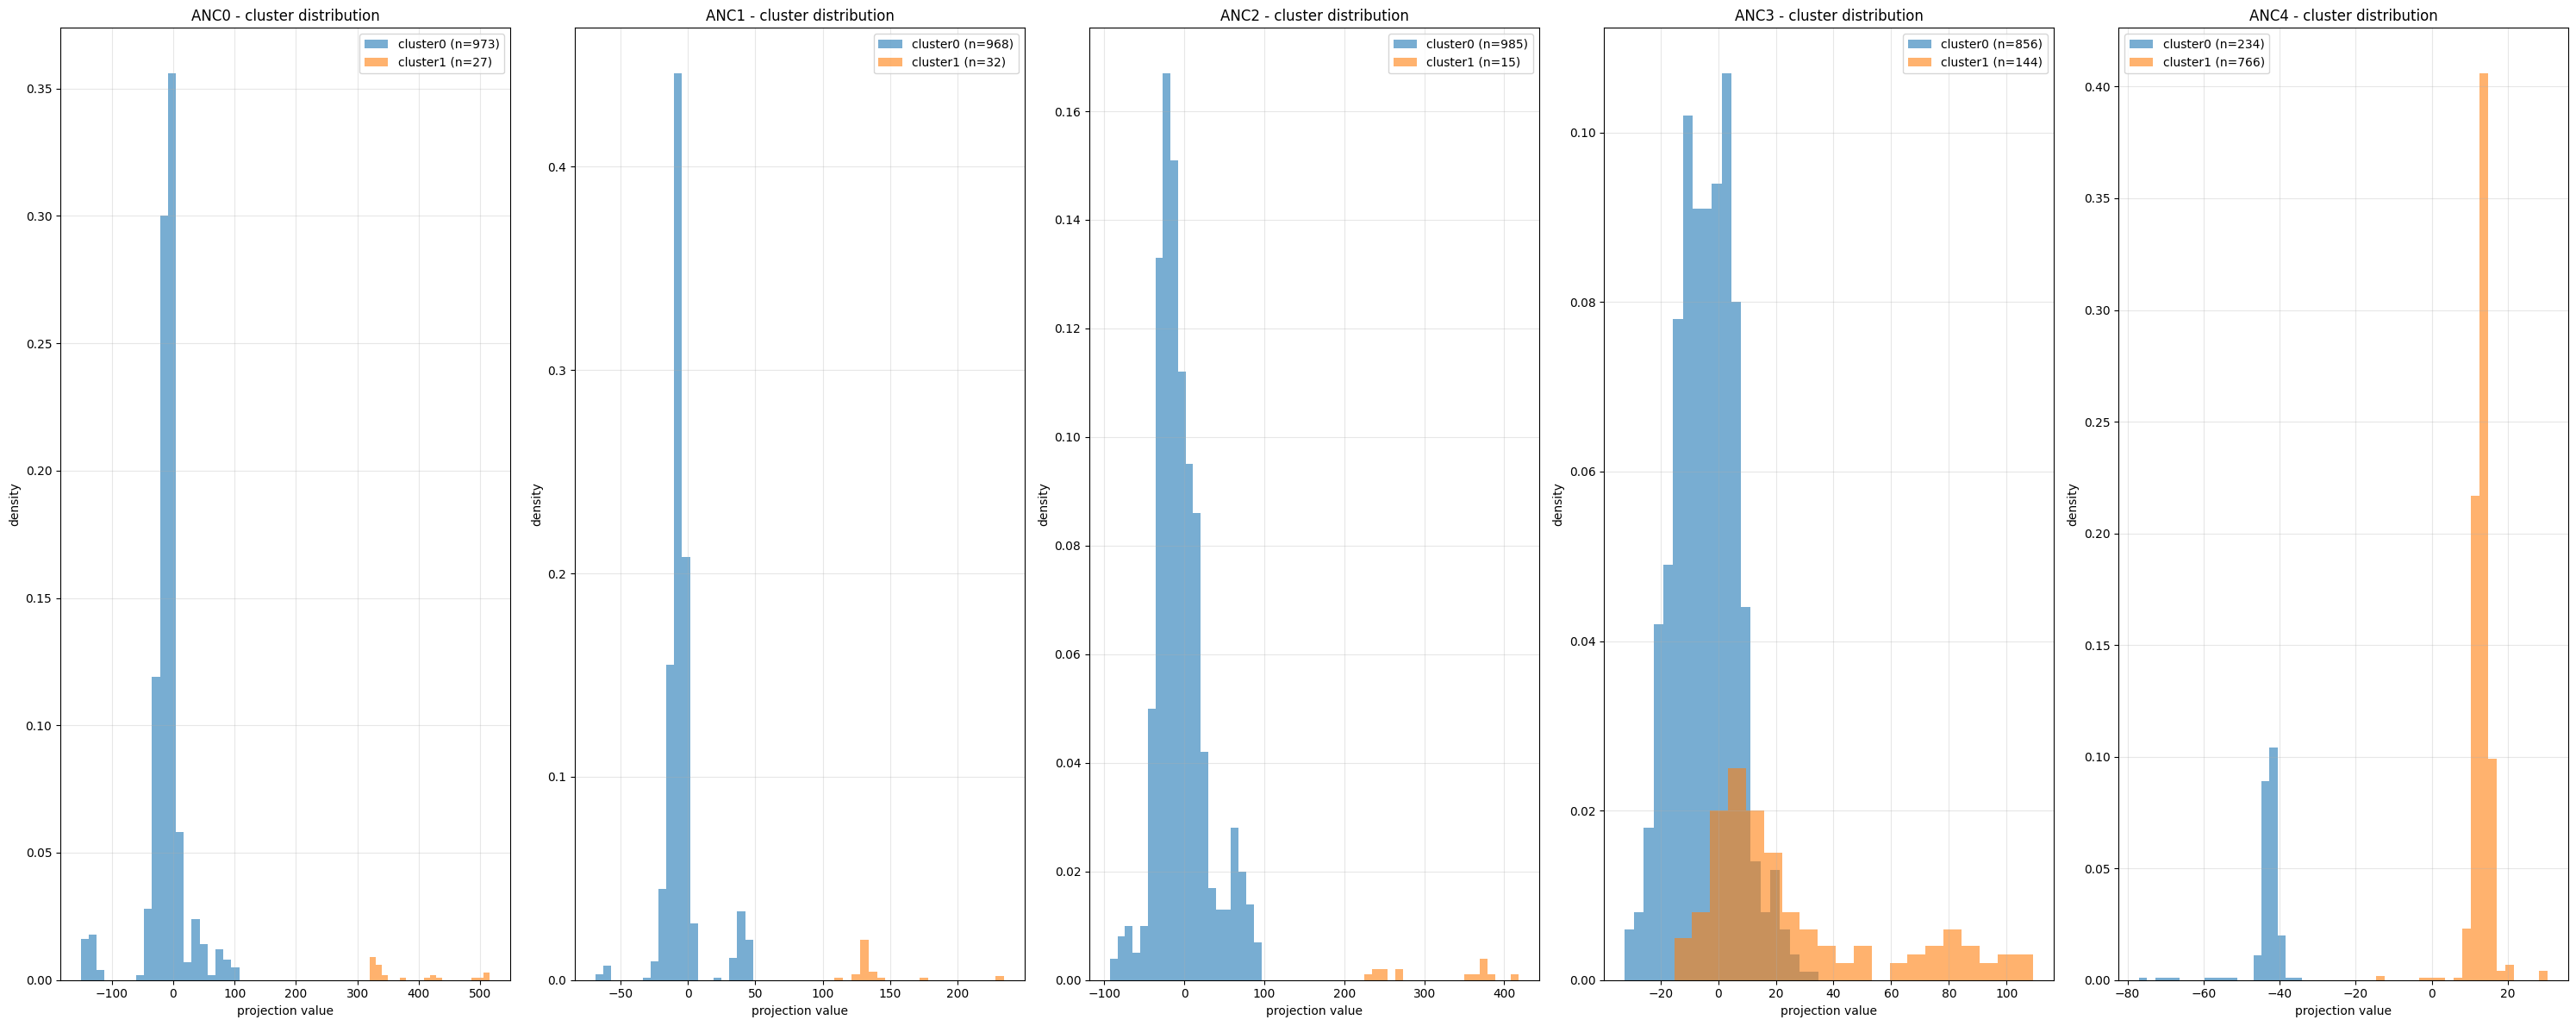

In [8]:
anc0_seqs_path = f"/yezhirui/evo_probe/data/sample/node499_anc0_samples.fasta"
mj_dict = load_mj_matrix("/yezhirui/evo_probe/data/mj_matrix.txt")
anc0_contact_embedding = generate_contact_embedding(anc0_seqs_path, critical_contacts , mj_dict)
print(f"contact_embedding shape: {anc0_contact_embedding.shape}")

anc1_seqs_path = f"/yezhirui/evo_probe/data/sample/node500_anc1_samples.fasta"
anc1_contact_embedding = generate_contact_embedding(anc1_seqs_path, critical_contacts , mj_dict)

anc2_seqs_path = f"/yezhirui/evo_probe/data/sample/node501_anc2_samples.fasta"
anc2_contact_embedding = generate_contact_embedding(anc2_seqs_path, critical_contacts , mj_dict)

anc3_seqs_path = f"/yezhirui/evo_probe/data/sample/node502_anc3_samples.fasta"
anc3_contact_embedding = generate_contact_embedding(anc3_seqs_path, critical_contacts , mj_dict)

anc4_seqs_path = f"/yezhirui/evo_probe/data/sample/node507_anc4_samples.fasta"
anc4_contact_embedding = generate_contact_embedding(anc4_seqs_path, critical_contacts , mj_dict)


# # 分析anc0数据
# print("=== ANC0 GMM分析 ===")
# k_vals, bic_scores,  best_k = gmm_bic_analysis(anc0_contact_embedding, max_k=5, verbose=True)

# # 绘制BIC曲线
# plot_bic_curve(k_vals, bic_scores, "ANC0 GMM BIC score curve")


# # 使用最优k值进行聚类
# gmm_model, gmm_labels, gmm_probs = gmm_cluster_analysis(anc0_contact_embedding, 2)
# print(f"GMM聚类结果: {len(np.unique(gmm_labels))}个聚类")
# print(f"各聚类大小: {np.bincount(gmm_labels)}")


datasets = {
    'ANC0': anc0_contact_embedding,
    'ANC1': anc1_contact_embedding,
    'ANC2': anc2_contact_embedding,
    'ANC3': anc3_contact_embedding,
    'ANC4': anc4_contact_embedding
}

all_results = compare_gmm_guided_projections(
    datasets,
    k=2,
    figsize=(30, 12)
)

  